In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV #for best parameters
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

from scipy.stats import chi2 #for McNemar's test
from scipy import stats
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [51]:
# Read Dataset
df = pd.read_csv("HTRU_2_UCI.csv",names=["Mean_IP","SD_IP","EK_IP","S_IP","Mean_C","SD_C","EK_C","S_C","Class"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Mean_IP  17898 non-null  float64
 1   SD_IP    17898 non-null  float64
 2   EK_IP    17898 non-null  float64
 3   S_IP     17898 non-null  float64
 4   Mean_C   17898 non-null  float64
 5   SD_C     17898 non-null  float64
 6   EK_C     17898 non-null  float64
 7   S_C      17898 non-null  float64
 8   Class    17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [52]:
df.head(3)

,Mean_IP,SD_IP,EK_IP,S_IP,Mean_C,SD_C,EK_C,S_C,Class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0


In [53]:
# Original Dataset Statistics Summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Mean_IP,17898.0,111.079968,25.652935,5.812500,100.929688,115.078125,127.085938,192.617188
SD_IP,17898.0,46.549532,6.843189,24.772042,42.376018,46.947479,51.023202,98.778911
EK_IP,17898.0,0.477857,1.064040,-1.876011,0.027098,0.223240,0.473325,8.069522
S_IP,17898.0,1.770279,6.167913,-1.791886,-0.188572,0.198710,0.927783,68.101622
Mean_C,17898.0,12.614400,29.472897,0.213211,1.923077,2.801839,5.464256,223.392140
SD_C,17898.0,26.326515,19.470572,7.370432,14.437332,18.461316,28.428104,110.642211
EK_C,17898.0,8.303556,4.506092,-3.139270,5.781506,8.433515,10.702959,34.539844
S_C,17898.0,104.857709,106.514540,-1.976976,34.960504,83.064556,139.309331,1191.000837
Class,17898.0,0.091574,0.288432,0.000000,0.000000,0.000000,0.000000,1.000000


In [54]:
# Check missing values
df.isna().sum() 

Mean_IP    0
SD_IP      0
EK_IP      0
S_IP       0
Mean_C     0
SD_C       0
EK_C       0
S_C        0
Class      0
dtype: int64

In [55]:
# Check duplicated records
df.duplicated().sum()

0

<AxesSubplot:>

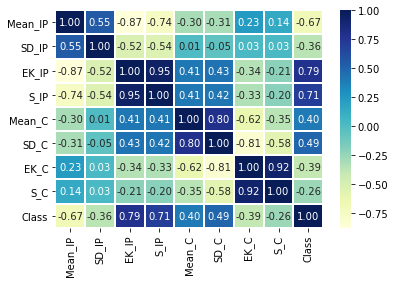

In [56]:
#correlation between features and class
corr = df.corr()
sns.heatmap(data=corr,annot=True,cmap="YlGnBu",linewidths=1,fmt=".2f")

In [11]:
#Counter(df['Class'])

print("True pulsar:",Counter(df['Class'])[1])
print("Fake pulsar:",Counter(df['Class'])[0])
print("True pulsar in this dataset: "+str(round(Counter(df['Class'])[1] / Counter(df['Class'])[0]*100,2))+"%" )

True pulsar: 1639
Fake pulsar: 16259
True pulsar in this dataset: 10.08%


In [110]:
# Check outliers
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = round((Q3 - Q1),2)
print("IQR score:")
print(IQR)

# lower = Q1 - (1.5 * IQR)    # upper = Q3 + (1.5 * IQR)

no_outliers = ((df < (Q1 - (1.5 * IQR))) | (df > ( Q3 + (1.5 * IQR)))).sum()
print("\nNumber of outliers:")
print(no_outliers)


per_outliers = round(100* (no_outliers / len(df)),2)
print("\nPercentage of outliers: % ")
print(per_outliers)


IQR score:
Mean_IP     26.16
SD_IP        8.65
EK_IP        0.45
S_IP         1.12
Mean_C       3.54
SD_C        13.99
EK_C         4.92
S_C        104.35
Class        0.00
dtype: float64

Number of outliers:
Mean_IP    1030
SD_IP       262
EK_IP      1589
S_IP       1894
Mean_C     2927
SD_C       2346
EK_C        488
S_C         901
Class      1639
dtype: int64

Percentage of outliers: % 
Mean_IP     5.75
SD_IP       1.46
EK_IP       8.88
S_IP       10.58
Mean_C     16.35
SD_C       13.11
EK_C        2.73
S_C         5.03
Class       9.16
dtype: float64


array([<AxesSubplot:title={'center':'Mean_C'}, xlabel='Class'>,
       <AxesSubplot:title={'center':'SD_C'}, xlabel='Class'>],
      dtype=object)

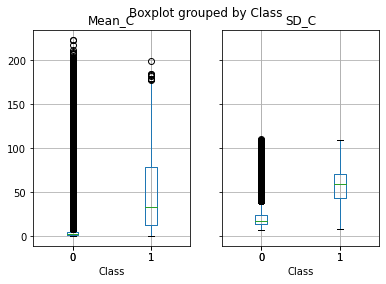

In [231]:
df.boxplot(column=("Mean_C","SD_C"),by="Class")

In [114]:
df = df.astype({"Class":str}) 

features = df.drop("Class",axis=1)  # (17898, 8)

label = np.array(df['Class']).reshape(-1, ) # (17898,)

[0.8711 0.9493 0.9905 0.9967 0.9991 1.0001 1.0001 1.0001]


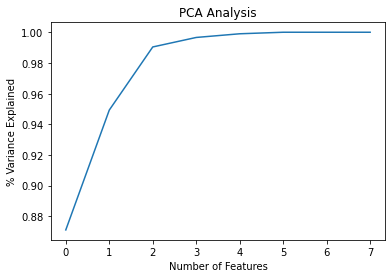

In [16]:
pca= PCA()
#dt = scale(features)
df_pca = pca.fit_transform(features)
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print(var)

plt.ylabel("% Variance Explained")
plt.xlabel("Number of Features")
plt.title("PCA Analysis")
plt.plot(var)
plt.show()

In [149]:
#X_td/X_test is training / held-out test data
X_td, X_test, y_td, y_test = train_test_split(features, label, test_size=0.2,random_state=1) # so we get the same results

# split X_td to training part and development part
X_train, X_dev, y_train, y_dev = train_test_split(X_td, y_td, test_size=0.3, random_state=1)


X_train.shape, X_dev.shape, X_test.shape,  y_train.shape, y_dev.shape, y_test.shape

((10022, 8), (4296, 8), (3580, 8), (10022,), (4296,), (3580,))

In [150]:
# Check class balance
print("True pulsar in Train set: "+str(round(Counter(y_train)['1'] / Counter(y_train)['0']*100,2))+"%" )
print("True pulsar in Validation set: "+str(round(Counter(y_dev)['1'] / Counter(y_dev)['0']*100,2))+"%" )
print("True pulsar in Test set: "+str(round(Counter(y_test)['1'] / Counter(y_test)['0']*100,2))+"%" )

True pulsar in Train set: 10.24%
True pulsar in Validation set: 9.7%
True pulsar in Test set: 10.09%


In [151]:
# Normalisation
minmaxscale = MinMaxScaler(feature_range=(0,1)).fit(X_train)

X_train = pd.DataFrame(minmaxscale.transform(X_train),columns=features.columns)
X_dev = pd.DataFrame(minmaxscale.transform(X_dev),columns=features.columns)
X_test = pd.DataFrame(minmaxscale.transform(X_test),columns=features.columns)


In [156]:
# Fine tuining for Random Forest model
param_rf = [{'criterion':['entropy', 'gini'],
          'max_depth':[6,8,10,15,20,30],
          'max_features' : ["auto", "sqrt", "log2"],
          'n_estimators':[20,30,50]}]
f1 = make_scorer(f1_score, pos_label='1', average='binary')
rf_cv = GridSearchCV(RandomForestClassifier(class_weight='balanced'), param_rf, scoring=f1, cv = 10)
rf_cv.fit(X_train, y_train)

print('Best parameters:',rf_cv.best_params_)
print('\nClassification report of validation set:')
print(classification_report(y_dev, rf_cv.predict(X_dev)))

Best parameters: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'n_estimators': 30}

Classification report of validation set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3916
           1       0.94      0.82      0.87       380

    accuracy                           0.98      4296
   macro avg       0.96      0.91      0.93      4296
weighted avg       0.98      0.98      0.98      4296



In [217]:
# Fine tuining for Logistic Regression model
param_lr = [{'max_iter':[2,4,6,8,10,25],
            'multi_class':['auto', 'ovr', 'multinomial'],
            'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'penalty':['l1', 'l2', 'elasticnet']}]
f1 = make_scorer(f1_score, pos_label='1', average='binary')
lr_cv = GridSearchCV(LogisticRegression(class_weight='balanced'), param_lr,  scoring=f1, cv = 10)
lr_cv.fit(X_train, y_train)

print('Best parameters:',lr_cv.best_params_)
print('\nClassification report of validation set:')
print(classification_report(y_dev, lr_cv.predict(X_dev)))

Best parameters: {'max_iter': 25, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}

Classification report of validation set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3916
           1       0.79      0.88      0.83       380

    accuracy                           0.97      4296
   macro avg       0.89      0.93      0.91      4296
weighted avg       0.97      0.97      0.97      4296



In [158]:
# Fine tuining for KNN model
param_knn = [{'n_neighbors':[3,5,7,9,11],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
               'weights':['uniform', 'distance']}]
f1 = make_scorer(f1_score, pos_label='1', average='binary')
knn_cv = GridSearchCV(KNeighborsClassifier(), param_knn, scoring=f1, cv = 10)
knn_cv.fit(X_train, y_train)

print('Best parameters:',knn_cv.best_params_)
print('\nClassification report of validation data:')
print(classification_report(y_dev, knn_cv.predict(X_dev)))

Best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}

Classification report of validation data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3916
           1       0.94      0.80      0.87       380

    accuracy                           0.98      4296
   macro avg       0.96      0.90      0.93      4296
weighted avg       0.98      0.98      0.98      4296



In [159]:
# Fine tuining for LinearSVC model
param_svc = [{'penalty':['l1', 'l2'],
               'loss':['hinge', 'squared_hinge'], 
               'C':[0.01,0.1,1,10,100]}]
f1 = make_scorer(f1_score, pos_label='1', average='binary')
svc_cv = GridSearchCV(LinearSVC(class_weight ='balanced'), param_svc, scoring=f1, cv = 10)
svc_cv.fit(X_train, y_train)

print('Best parameters:',svc_cv.best_params_)
print('\nClassification report of validation data:')
print(classification_report(y_dev, svc_cv.predict(X_dev)))

Best parameters: {'C': 100, 'loss': 'squared_hinge', 'penalty': 'l2'}

Classification report of validation data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3916
           1       0.89      0.87      0.88       380

    accuracy                           0.98      4296
   macro avg       0.94      0.93      0.93      4296
weighted avg       0.98      0.98      0.98      4296



In [153]:
# Naive Bayes
# Naive Bayes without fine tuning
nb = GaussianNB() # the depth of the tree
_ = nb.fit(X_train, y_train)

# Evaluate
print('Classification report of validation data:')
print(classification_report(y_dev, nb.predict(X_dev)))

Classification report of validation data:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3916
           1       0.65      0.84      0.73       380

    accuracy                           0.95      4296
   macro avg       0.82      0.90      0.85      4296
weighted avg       0.95      0.95      0.95      4296



In [154]:
#feature importance - NB

important = permutation_importance(nb, X_train,y_train, scoring="accuracy")
imp = important.importances_mean
importances = pd.DataFrame({'feature':X_train.columns, 'importance':imp})
importances = importances.sort_values('importance', ascending=False).set_index('feature')
importances.head()

,importance
feature,
EK_IP,0.053263
S_IP,0.051128
Mean_IP,0.012971
SD_IP,-0.000519
S_C,-0.006107


<AxesSubplot:ylabel='feature'>

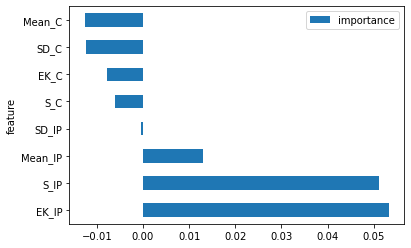

In [155]:
importances.plot.barh()

In [222]:
# F1 score of each model for 10 folds  -- TEST data
start = time.time()
rf_f1 = cross_val_score(rf_cv, X_test, y_test, cv=10, scoring='f1_micro') #benchmark model
lr_f1 = cross_val_score(lr_cv, X_test, y_test, cv=10, scoring='f1_micro')
knn_f1 = cross_val_score(knn_cv, X_test, y_test, cv=10, scoring='f1_micro')
svc_f1 = cross_val_score(svc_cv, X_test, y_test, cv=10, scoring='f1_micro')
nb_f1 = cross_val_score(nb, X_test, y_test, cv=10, scoring='f1_micro')
end = time.time()-start

print(rf_f1, lr_f1, knn_f1, svc_f1, nb_f1)
print(end) # time

[0.98044693 0.98324022 0.98324022 0.96368715 0.97486034 0.98603352
 0.98044693 0.96648045 0.98603352 0.98044693] [0.96089385 0.97206704 0.97486034 0.95251397 0.97486034 0.97206704
 0.97765363 0.96368715 0.96927374 0.97206704] [0.97206704 0.97765363 0.98044693 0.96648045 0.97486034 0.98603352
 0.98882682 0.96927374 0.97486034 0.97486034] [0.98044693 0.98603352 0.97765363 0.96648045 0.98324022 0.98882682
 0.58659218 0.96648045 0.97486034 0.97486034] [0.93575419 0.95530726 0.95251397 0.94413408 0.94972067 0.95251397
 0.93575419 0.93575419 0.95251397 0.95530726]
2356.340786218643


In [241]:
# Average F1-score

round(np.mean(rf_f1),4), round(np.mean(lr_f1),4), round(np.mean(knn_f1),4), round(np.mean(svc_f1),4), round(np.mean(nb_f1),4)

# The RandomForest model has the highest average F1-score.

(0.9785, 0.969, 0.9765, 0.9385, 0.9469)

In [224]:
# Compute the Kruskal-Wallis H-test for independent samples. For >=10 observation

lr_rf_f1 = stats.kruskal(rf_f1, lr_f1)
knn_rf_f1 = stats.kruskal(rf_f1, knn_f1)
svc_rf_f1 = stats.kruskal(rf_f1, svc_f1)
nb_rf_f1 = stats.kruskal(rf_f1, nb_f1)


In [225]:
# Determine whether to reject or accept H0

def reject_accept(score):
    alpha = 0.05
    print("Pvalue is:",round(score,5))
    if score > alpha:
        print("Accept H0, There is no difference.")
    else:
        print("Reject H0, They are significantly different.")

In [236]:
print("Logistic Regression VS Random Forest")
reject_accept(lr_rf_f1[1])

print("\nKNN VS Random Forest")
reject_accept(knn_rf_f1[1])

print("\nSVM VS Random Forest")
reject_accept(svc_rf_f1[1])

print("\nNaive Bayes VS Random Forest")
reject_accept(nb_rf_f1[1])

Logistic Regression VS Random Forest
Pvalue is: 0.01087
Reject H0, They are significantly different.

KNN VS Random Forest
Pvalue is: 0.42278
Accept H0, There is no difference.

SVM VS Random Forest
Pvalue is: 0.51639
Accept H0, There is no difference.

Naive Bayes VS Random Forest
Pvalue is: 0.00014
Reject H0, They are significantly different.


In [227]:
# Accuracy of each model for 10 folds  -- TEST data
start = time.time()

rf_acc = cross_val_score(rf_cv, X_test, y_test, cv=10, scoring='accuracy') #benchmark model
lr_acc = cross_val_score(lr_cv, X_test, y_test, cv=10, scoring='accuracy')
knn_acc = cross_val_score(knn_cv, X_test, y_test, cv=10, scoring='accuracy')
svc_acc = cross_val_score(svc_cv, X_test, y_test, cv=10, scoring='accuracy')
nb_acc = cross_val_score(nb, X_test, y_test, cv=10, scoring='accuracy')
end = time.time()-start

print(rf_acc, lr_acc, knn_acc, svc_acc, nb_acc)
print(end,"s")

[0.97765363 0.98324022 0.98324022 0.96648045 0.97486034 0.98603352
 0.98882682 0.97206704 0.98603352 0.97765363] [0.96089385 0.95810056 0.97486034 0.96648045 0.96648045 0.95251397
 0.97486034 0.96368715 0.96927374 0.96089385] [0.97206704 0.97765363 0.98044693 0.96648045 0.97486034 0.98603352
 0.98882682 0.96927374 0.97486034 0.97486034] [0.98044693 0.98324022 0.97765363 0.96089385 0.98324022 0.98603352
 0.94972067 0.96368715 0.96927374 0.97206704] [0.93575419 0.95530726 0.95251397 0.94413408 0.94972067 0.95251397
 0.93575419 0.93575419 0.95251397 0.95530726]
2628.3023459911346 s


In [237]:
# Average accuracy on TEST data

round(np.mean(rf_acc),4), round(np.mean(lr_acc),4), round(np.mean(knn_acc),4), round(np.mean(svc_acc),4), round(np.mean(nb_acc),4)


# The Random Forest model has the highest average accuracy.

(0.9796, 0.9648, 0.9765, 0.9726, 0.9469)

In [229]:
# Compute the Kruskal-Wallis H-test for independent samples. For >=10 observation

lr_rf_acc = stats.kruskal(rf_acc, lr_acc)
knn_rf_acc = stats.kruskal(rf_acc, knn_acc)
svc_rf_acc = stats.kruskal(rf_acc, svc_acc)
nb_rf_acc = stats.kruskal(rf_acc, nb_acc)

In [230]:
print("Decision Tree VS Random Forest")
reject_accept(lr_rf_acc[1])

print("\nKNN VS Random Forest")
reject_accept(knn_rf_acc[1])

print("\nSVM VS Random Forest")
reject_accept(svc_rf_acc[1])

print("\nNaive Bayes VS Random Forest")
reject_accept(nb_rf_acc[1])

Decision Tree VS Random Forest
Pvalue is: 0.00109
Reject H0, They are significantly different.

KNN VS Random Forest
Pvalue is: 0.32172
Accept H0, There is no difference.

SVM VS Random Forest
Pvalue is: 0.15896
Accept H0, There is no difference.

Naive Bayes VS Random Forest
Pvalue is: 0.00015
Reject H0, They are significantly different.


In [256]:
# final model - Random Forest
st = time.time()
rf = RandomForestClassifier(class_weight='balanced',
                            criterion='gini', 
                            max_depth=30, 
                            max_features= 'log2', 
                            n_estimators=30)
_ = rf.fit(X_train,y_train)
rf_result = rf.predict(X_test)
print('\nClassification report of test data:')
print(classification_report(y_dev, rf.predict(X_dev)))
end = round((time.time() - st),3)
print("TIME:",end,'s')


Classification report of test data:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3916
           1       0.95      0.81      0.87       380

    accuracy                           0.98      4296
   macro avg       0.96      0.90      0.93      4296
weighted avg       0.98      0.98      0.98      4296

TIME: 1.39 s
